<div style="background-color: #add8e6; padding: 10px; color: black; padding-top: 2rem; padding-left: 1rem">

# Project Outline

</div>

In this kaggle assignment I am going to create an algorithm to identify metastatic cancer in small image patches taken from larger digital pathology scans. The data for this competition is a slightly modified version of the PatchCamelyon (PCam) benchmark dataset (the original PCam dataset contains duplicate images due to its probabilistic sampling, however, the version presented on Kaggle does not contain duplicates).

PCam is highly interesting for both its size, simplicity to get started on, and approachability. In the authors' words:

[PCam] packs the clinically-relevant task of metastasis detection into a straight-forward binary image classification task, akin to CIFAR-10 and MNIST. Models can easily be trained on a single GPU in a couple hours, and achieve competitive scores in the Camelyon16 tasks of tumor detection and whole-slide image diagnosis. Furthermore, the balance between task-difficulty and tractability makes it a prime suspect for fundamental machine learning research on topics as active learning, model uncertainty, and explainability.

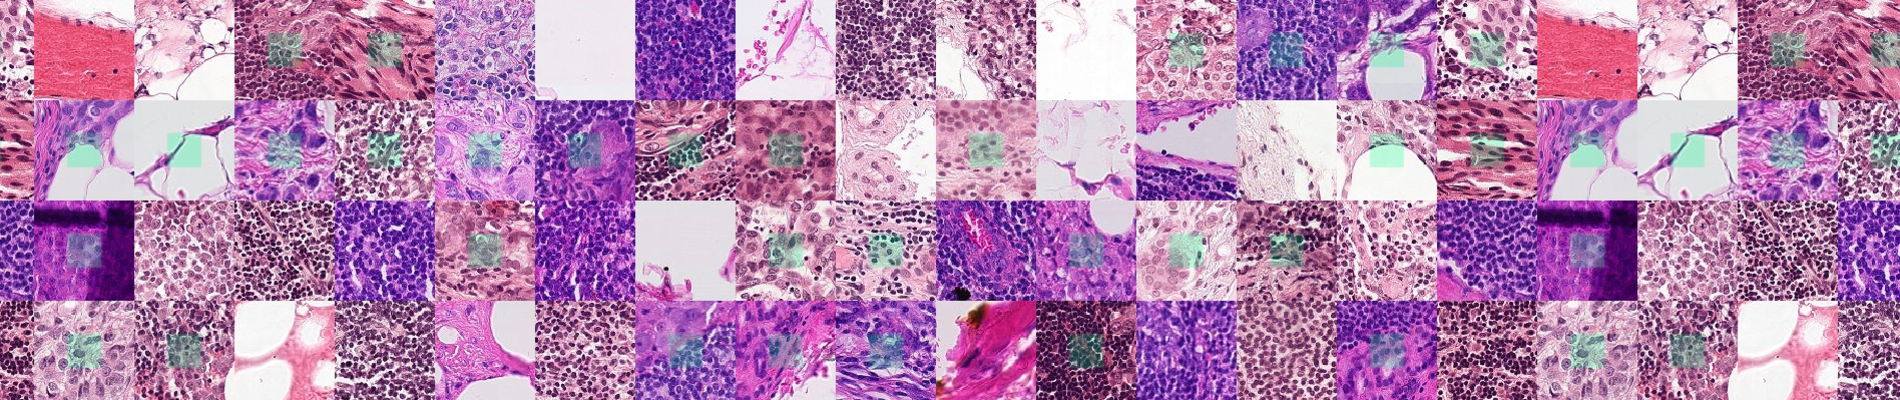

## Imports

In [1]:
#Library imports
import os
import numpy as np
import pandas as pd
import shutil
import cv2 as cv
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import RandomFlip, RandomZoom, RandomRotation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.utils import shuffle
from skimage.transform import rotate
from skimage import io

In [2]:
trainDataFrame = pd.read_csv('../input/histopathologic-cancer-detection/train_labels.csv')
sampleSubmissionDataFrame = pd.read_csv('../input/histopathologic-cancer-detection/sample_submission.csv')
testDataFrame = pd.DataFrame({'id':os.listdir('../input/histopathologic-cancer-detection/test/')})

<div style="background-color: #add8e6; padding: 10px; color: black; padding-top: 2rem; padding-left: 1rem">

# Data Inspection (EDA Pt. 1)

</div>

In this dataset, I am provided with a large number of small pathology images to classify. Files are named with an image id. The train_labels.csv file provides the ground truth for the images in the train folder. I am predicting the labels for the images in the test folder. A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label. This outer region is provided to enable fully-convolutional models that do not use zero-padding, to ensure consistent behavior when applied to a whole-slide image.

The original PCam dataset contains duplicate images due to its probabilistic sampling, however, the version presented on Kaggle does not contain duplicates. We have otherwise maintained the same data and splits as the PCam benchmark.



Total Files: 277485
Overall File Size: 7.76 GB
File Type: tif, csv
File Structure: test folder, train folder, sampleSubmissionDataFrame.csv, and train_labels.csv

In [3]:
sampleSubmissionDataFrame.info()
sampleSubmissionDataFrame.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57458 entries, 0 to 57457
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      57458 non-null  object
 1   label   57458 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 897.9+ KB


id  label
0  0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5      0
1  95596b92e5066c5c52466c90b69ff089b39f2737      0
2  248e6738860e2ebcf6258cdc1f32f299e0c76914      0
3  2c35657e312966e9294eac6841726ff3a748febf      0
4  145782eb7caa1c516acbe2eda34d9a3f31c41fd6      0
5  725dabe6ecccc68b958a2c7dd75bcbf362c7cb03      0
6  aa0307865281d4484ddf8c637c348292968b93a7      0
7  f4e5dc9c949920f1b3362982e15e99bf6f3ef83b      0
8  95e08c9cedc28a9b4a86f4fc1e06c1972134be08      0
9  ee1f5345a8d4e28403b7e61b97b5f76c201ce9cb      0

In [4]:
trainDataFrame.info()
trainDataFrame.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0
5  acfe80838488fae3c89bd21ade75be5c34e66be7      0
6  a24ce148f6ffa7ef8eefb4efb12ebffe8dd700da      1
7  7f6ccae485af121e0b6ee733022e226ee6b0c65f      1
8  559e55a64c9ba828f700e948f6886f4cea919261      0
9  8eaaa7a400aa79d36c2440a4aa101cc14256cda4      0

In [5]:
testDataFrame.info()
testDataFrame.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57458 entries, 0 to 57457
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      57458 non-null  object
dtypes: object(1)
memory usage: 449.0+ KB


id
0  a7ea26360815d8492433b14cd8318607bcf99d9e.tif
1  59d21133c845dff1ebc7a0c7cf40c145ea9e9664.tif
2  5fde41ce8c6048a5c2f38eca12d6528fa312cdbb.tif
3  bd953a3b1db1f7041ee95ff482594c4f46c73ed0.tif
4  523fc2efd7aba53e597ab0f69cc2cbded7a6ce62.tif
5  d23c66547f4a00555a174d2fcb860ae399b66edc.tif
6  fabf2fca23f71655974767e29eda86a9b2c97a72.tif
7  9730b15862516b8641b9f0ff48db660d95031c32.tif
8  ee85348c0950c2e639776fb555e3452c1f8437c0.tif
9  ef12a0813c504d2d1b2ba485e78d380ad64a0622.tif

In [6]:
print(f"Sample Submission N: {sampleSubmissionDataFrame.shape[0]}")
print(f"Train Data N: {trainDataFrame.shape[0]}")
print(f"Test Data N: {testDataFrame.shape[0]}")

Sample Submission N: 57458
Train Data N: 220025
Test Data N: 57458


<div style="background-color: #add8e6; padding: 10px; color: black; padding-top: 2rem; padding-left: 1rem">

# Data Cleaning (EDA Pt. 2)

</div>

One of the training images wasnt visible and one was causing an error with in the dataset. Cleaning these two images out since the rest of the dataset was already very clean.

In [7]:
trainDataFrame[trainDataFrame['id'] != 'dd6dfed324f9fcb6f93f46f32fc800f2ec196be2']
trainDataFrame[trainDataFrame['id'] != '9369c7278ec8bcc6c880d99194de09fc2bd4efbe']

id  label
0       f38a6374c348f90b587e046aac6079959adf3835      0
1       c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2       755db6279dae599ebb4d39a9123cce439965282d      0
3       bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4       068aba587a4950175d04c680d38943fd488d6a9d      0
...                                          ...    ...
220020  53e9aa9d46e720bf3c6a7528d1fca3ba6e2e49f6      0
220021  d4b854fe38b07fe2831ad73892b3cec877689576      1
220022  3d046cead1a2a5cbe00b2b4847cfb7ba7cf5fe75      0
220023  f129691c13433f66e1e0671ff1fe80944816f5a2      0
220024  a81f84895ddcd522302ddf34be02eb1b3e5af1cb      1

[220024 rows x 2 columns]

<div style="background-color: #add8e6; padding: 10px; color: black; padding-top: 2rem; padding-left: 1rem">

# Data Visualization (EDA Pt. 3)

</div>

From looking at the pie chart and count plot, you can tell that there are about 60% non cancerous tissues found and about 40% cancerous tissues found. This means our data is pretty balanced as far as predictions goes so this should help when trying to make an accurate model.

<AxesSubplot:title={'center':'Category Images'}, ylabel='label'>

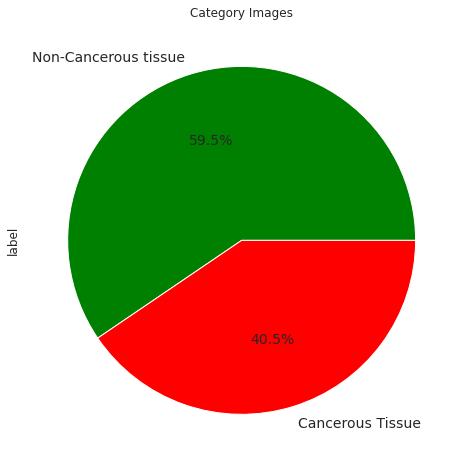

In [8]:
sns.set(style='whitegrid')
colors = ['green', 'red']
pieChart=pd.DataFrame(trainDataFrame['label'].replace(0,'Non-Cancerous tissue').replace(1,'Cancerous Tissue').value_counts())
pieChart.reset_index(inplace=True)
pieChart.plot(kind='pie', title='Category Images',y = 'label', 
             autopct='%1.1f%%', shadow=False, labels=pieChart['index'], legend = False, fontsize=14, figsize=(15,8), colors= colors)

0    130908
1     89117
Name: label, dtype: int64


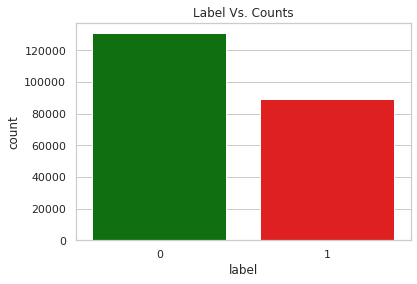

In [9]:
print(trainDataFrame['label'].value_counts())
sns.countplot(x=trainDataFrame['label'], palette=["green", "red"]).set(title='Label Vs. Counts');

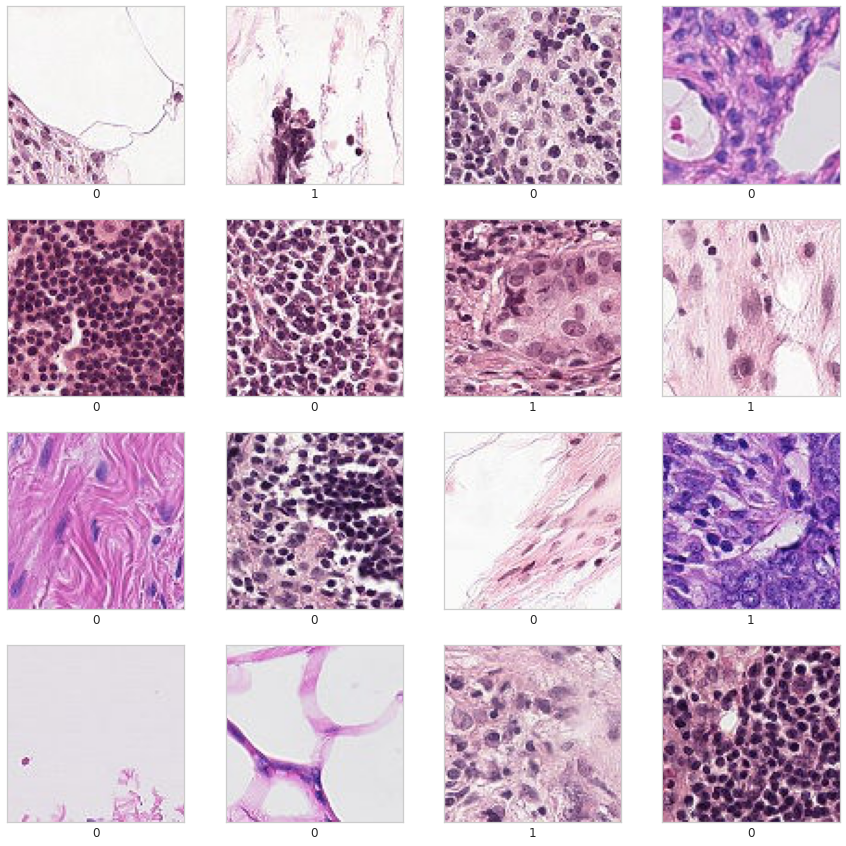

In [10]:
#Image Visualisations
fig, ax = plt.subplots(4, 4, figsize=(15, 15))
for i, axis in enumerate(ax.flat):
    axis.imshow(io.imread(str('../input/histopathologic-cancer-detection/train/' + trainDataFrame.id[i] + '.tif')))
    axis.set(xticks=[], yticks=[], xlabel = trainDataFrame.label[i]);

<div style="background-color: #add8e6; padding: 10px; color: black; padding-top: 2rem; padding-left: 1rem">

# Model Architecture

</div>

For this project, I will be implementing two different convolutional neural networks (CNN) models. The first model I'm using with use no hyperparameters or tuning at all. The second model with have the use of hyperparameters to tune the model more. These two models consist of two convolutional layers which are then followed by a MaxPool layer. This pattern is then repeating N times. The model will following the input then go to the two convolutional layers then max pool then two convolutional layers then max pool then itll flatten and then produce and output with a sigmoid activation.

Model 1:
* Normalizes the images pre training
* Output layer activation: sigmoid

Model 2:
* Inherits all of the parameters from the first model
    * Uses the sigmoid for binary data
* Has a dropout of 0.1
    * Setting it to this allows for regularization by randomly setting some weights to 0 during training.
* Applies Batch Normalization
    * Dividing the pixel values by 255 to normalize data between 0 and 1
* Using Adam Optimization
    * Adam Optimization incorporates momentum for gradient and gradient-squared
* Applies a Learning rate of 0.0001
    * I used this value to help regulate the speed of the learning during gradient descent to help minimize overshooting
* Has a hidden layer activation of ReLU
    * ReLU helps aid in convergence, preventing saturation and reducing the overall computational demand


<div style="background-color: #add8e6; padding: 10px; color: black; padding-top: 2rem; padding-left: 1rem">

# Analysis / Hyperparameter Tuning

</div>

In [11]:
def append_tif(string):
    return string+".tif"

trainDataFrame["id"] = trainDataFrame["id"].apply(append_tif)
trainDataFrame['label'] = trainDataFrame['label'].astype(str)
trainDataFrame = shuffle(trainDataFrame, random_state=101)

In [12]:
datagen = ImageDataGenerator(rescale=1./255.,
                            validation_split=0.15)

In [13]:
trainDataGen = datagen.flow_from_dataframe(
    dataframe=trainDataFrame,
    directory='../input/histopathologic-cancer-detection/train/',
    x_col="id",
    y_col="label",
    subset="training",
    batch_size=256,
    seed=101,
    class_mode="binary",
    target_size=(64,64))  

Found 187022 validated image filenames belonging to 2 classes.


In [14]:
validDataGen = datagen.flow_from_dataframe(
    dataframe=trainDataFrame,
    directory='../input/histopathologic-cancer-detection/train/',
    x_col="id",
    y_col="label",
    subset="validation",
    batch_size=256,
    seed=101,
    class_mode="binary",
    target_size=(64,64))  

Found 33003 validated image filenames belonging to 2 classes.


In [15]:
tpu = None
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy()

<div style="background-color: #add8e6; padding: 10px; color: black; padding-top: 2rem; padding-left: 1rem">

# Model 1 (No Tuning)

</div>

In [16]:
model1Roc = tf.keras.metrics.AUC()

with strategy.scope():
    
    #model design
    modelOne = Sequential()
    
    modelOne.add(Conv2D(filters=16, kernel_size=(3,3)))
    modelOne.add(Conv2D(filters=16, kernel_size=(3,3)))
    modelOne.add(MaxPooling2D(pool_size=(2,2)))

    modelOne.add(Conv2D(filters=32, kernel_size=(3,3)))
    modelOne.add(Conv2D(filters=32, kernel_size=(3,3)))
    modelOne.add(AveragePooling2D(pool_size=(2,2)))

    modelOne.add(Flatten())
    modelOne.add(Dense(1, activation='sigmoid'))
    
    modelOne.build(input_shape=(256, 64, 64, 3))
    
    modelOne.compile(loss='binary_crossentropy', metrics=['accuracy', model1Roc])
    
modelOne.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (256, 62, 62, 16)         448       
_________________________________________________________________
conv2d_1 (Conv2D)            (256, 60, 60, 16)         2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (256, 30, 30, 16)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (256, 28, 28, 32)         4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (256, 26, 26, 32)         9248      
_________________________________________________________________
average_pooling2d (AveragePo (256, 13, 13, 32)         0         
_________________________________________________________________
flatten (Flatten)            (256, 5408)               0

In [17]:
histModelOne = modelOne.fit_generator(
                        trainDataGen,
                        epochs = 10,
                        validation_data = validDataGen)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
731/731 [==============================] - 1555s 2s/step - loss: 0.5958 - accuracy: 0.6947 - auc: 0.7385 - val_loss: 0.5336 - val_accuracy: 0.7506 - val_auc: 0.8079
Epoch 2/10
731/731 [==============================] - 499s 683ms/step - loss: 0.5359 - accuracy: 0.7456 - auc: 0.8010 - val_loss: 0.5127 - val_accuracy: 0.7625 - val_auc: 0.8235
Epoch 3/10
731/731 [==============================] - 504s 690ms/step - loss: 0.5094 - accuracy: 0.7615 - auc: 0.8231 - val_loss: 0.4898 - val_accuracy: 0.7696 - val_auc: 0.8481
Epoch 4/10
731/731 [==============================] - 533s 730ms/step - loss: 0.4876 - accuracy: 0.7747 - auc: 0.8397 - val_loss: 0.5567 - val_accuracy: 0.7165 - val_auc: 0.8554
Epoch 5/10
731/731 [==============================] - 530s 725ms/step - loss: 0.4758 - accuracy: 0.7822 - auc: 0.8479 - val_loss: 0.4858 - val_accuracy: 0.7761 - val_auc: 0.8614
Epoch 6/10
731/731 [==============================] - 513s 702ms/step - loss: 0.4673 - accuracy: 0.7862 - auc: 0

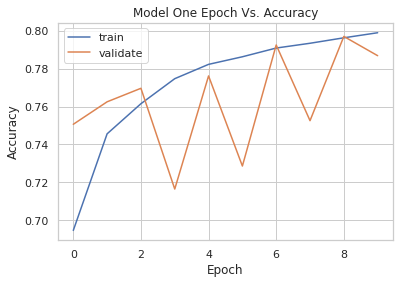

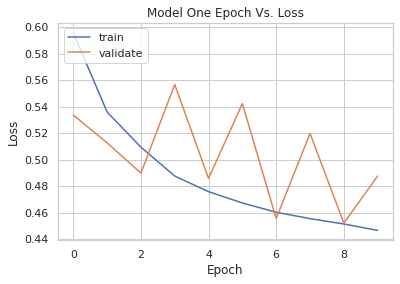

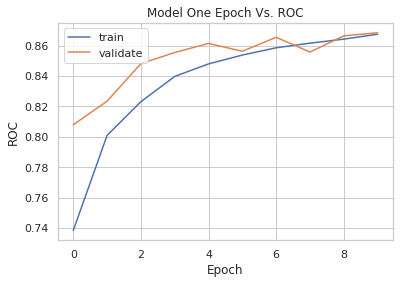

In [18]:
plt.plot(histModelOne.history['accuracy'])
plt.plot(histModelOne.history['val_accuracy'])
plt.title('Model One Epoch Vs. Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

# plot model loss per epoch
plt.plot(histModelOne.history['loss'])
plt.plot(histModelOne.history['val_loss'])
plt.title('Model One Epoch Vs. Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

# plot model ROC per epoch
plt.plot(histModelOne.history['auc'])
plt.plot(histModelOne.history['val_auc'])
plt.title('Model One Epoch Vs. ROC')
plt.ylabel('ROC')
plt.xlabel('Epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

<div style="background-color: #add8e6; padding: 10px; color: black; padding-top: 2rem; padding-left: 1rem">

# Model 2 (Tuned with Hyperparameters)

</div>

In [19]:
model2Roc = tf.keras.metrics.AUC()

with strategy.scope():
    
    modelTwo = Sequential()
    
    modelTwo.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu', ))
    modelTwo.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu'))
    modelTwo.add(MaxPooling2D(pool_size=(2,2)))
    modelTwo.add(Dropout(0.1))
    
    modelTwo.add(BatchNormalization())
    modelTwo.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
    modelTwo.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
    modelTwo.add(AveragePooling2D(pool_size=(2,2)))
    modelTwo.add(Dropout(0.1))
    
    modelTwo.add(BatchNormalization())
    modelTwo.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
    modelTwo.add(Flatten())
    modelTwo.add(Dense(1, activation='sigmoid'))
    
    modelTwo.build(input_shape=(256, 64, 64, 3))
    
    adam_optimizer = Adam(learning_rate=0.0001)
    modelTwo.compile(loss='binary_crossentropy', metrics=['accuracy', model2Roc], optimizer=adam_optimizer)

modelTwo.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (256, 62, 62, 16)         448       
_________________________________________________________________
conv2d_5 (Conv2D)            (256, 60, 60, 16)         2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (256, 30, 30, 16)         0         
_________________________________________________________________
dropout (Dropout)            (256, 30, 30, 16)         0         
_________________________________________________________________
batch_normalization (BatchNo (256, 30, 30, 16)         64        
_________________________________________________________________
conv2d_6 (Conv2D)            (256, 28, 28, 32)         4640      
_________________________________________________________________
conv2d_7 (Conv2D)            (256, 26, 26, 32)        

In [20]:
histModelTwo = modelTwo.fit_generator(
                        trainDataGen,
                        epochs = 10,
                        validation_data = validDataGen)

Epoch 1/10
731/731 [==============================] - 568s 775ms/step - loss: 0.4512 - accuracy: 0.7929 - auc_1: 0.8634 - val_loss: 0.5367 - val_accuracy: 0.7534 - val_auc_1: 0.8645
Epoch 2/10
731/731 [==============================] - 502s 686ms/step - loss: 0.3842 - accuracy: 0.8325 - auc_1: 0.9031 - val_loss: 0.4222 - val_accuracy: 0.8261 - val_auc_1: 0.9000
Epoch 3/10
731/731 [==============================] - 541s 740ms/step - loss: 0.3566 - accuracy: 0.8466 - auc_1: 0.9175 - val_loss: 0.4412 - val_accuracy: 0.8274 - val_auc_1: 0.9142
Epoch 4/10
731/731 [==============================] - 508s 695ms/step - loss: 0.3387 - accuracy: 0.8553 - auc_1: 0.9261 - val_loss: 0.6597 - val_accuracy: 0.8037 - val_auc_1: 0.8259
Epoch 5/10
731/731 [==============================] - 501s 686ms/step - loss: 0.3258 - accuracy: 0.8610 - auc_1: 0.9318 - val_loss: 0.5060 - val_accuracy: 0.8072 - val_auc_1: 0.9155
Epoch 6/10
731/731 [==============================] - 520s 711ms/step - loss: 0.3164 - acc

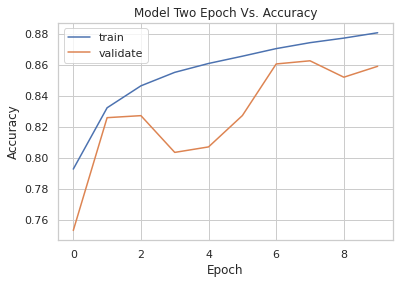

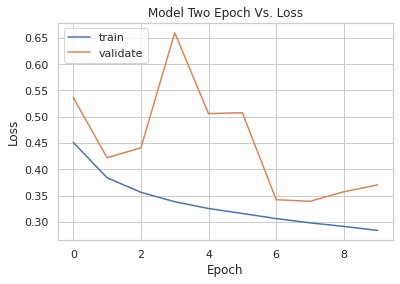

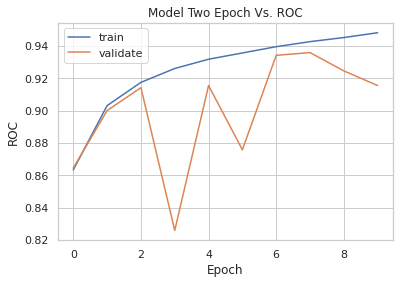

In [21]:
plt.plot(histModelTwo.history['accuracy'])
plt.plot(histModelTwo.history['val_accuracy'])
plt.title('Model Two Epoch Vs. Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

plt.plot(histModelTwo.history['loss'])
plt.plot(histModelTwo.history['val_loss'])
plt.title('Model Two Epoch Vs. Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

plt.plot(histModelTwo.history['auc_1'])
plt.plot(histModelTwo.history['val_auc_1'])
plt.title('Model Two Epoch Vs. ROC')
plt.ylabel('ROC')
plt.xlabel('Epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();


## Graph Summary
After comparing the plots above, you can see the model 2 has a higher degree of accuracy when looking at the data. Although its not a huge improvement it does show that the tuning did help improve the algorithm in this case. Comparing the AUC ROC scores as well you can tell the improvement in the model. Also the loss ends up being lower in the new model than the non tuned one.

In [22]:
datagenTest = ImageDataGenerator(rescale=1./255.)

testDataGen = datagenTest.flow_from_dataframe(
    dataframe=testDataFrame,
    directory='../input/histopathologic-cancer-detection/test/',
    x_col='id', 
    y_col=None,
    target_size=(64,64),         
    batch_size=1,
    shuffle=False,
    class_mode=None)

Found 57458 validated image filenames.


In [23]:
predictions = modelTwo.predict(testDataGen, verbose=1)

57458/57458 [==============================] - 418s 7ms/step


In [24]:
predictions = np.transpose(predictions)[0]
submissionDataFrame = pd.DataFrame()
submissionDataFrame['id'] = testDataFrame['id'].apply(lambda x: x.split('.')[0])
submissionDataFrame['label'] = list(map(lambda x: 0 if x < 0.5 else 1, predictions))
submissionDataFrame.head()

id  label
0  a7ea26360815d8492433b14cd8318607bcf99d9e      1
1  59d21133c845dff1ebc7a0c7cf40c145ea9e9664      0
2  5fde41ce8c6048a5c2f38eca12d6528fa312cdbb      0
3  bd953a3b1db1f7041ee95ff482594c4f46c73ed0      1
4  523fc2efd7aba53e597ab0f69cc2cbded7a6ce62      0

In [25]:
submissionDataFrame['label'].value_counts()

0    38835
1    18623
Name: label, dtype: int64

<AxesSubplot:title={'center':'Submission Image Classification'}, ylabel='label'>

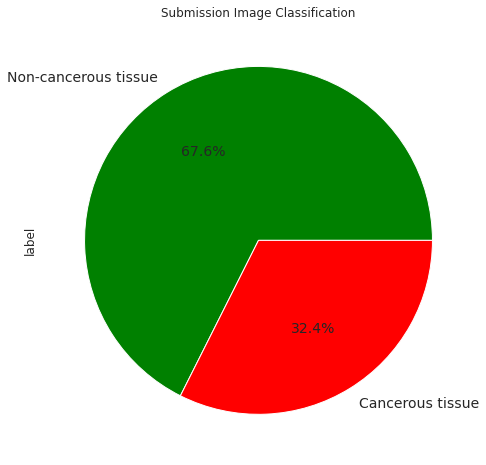

In [26]:
sns.set(style='whitegrid')
colors = ['green', 'red']
pieChart=pd.DataFrame(submissionDataFrame['label'].replace(0,'Non-cancerous tissue').replace(1,'Cancerous tissue').value_counts())
pieChart.reset_index(inplace=True)
pieChart.plot(kind='pie', title='Submission Image Classification',y = 'label', 
             autopct='%1.1f%%', shadow=False, labels=pieChart['index'], legend = False, fontsize=14, figsize=(18,8), colors= colors)

In [27]:
submissionDataFrame.to_csv('submission.csv', index=False)

<div style="background-color: #add8e6; padding: 10px; color: black; padding-top: 2rem; padding-left: 1rem">

# Conclusion

</div>

<ins>What I Learned / Key Takeaway</ins>\
Looking at all of the plots above, you can tell that the model 2 that was tuned using the hyperparameters ended up being better than the previous model 1 that was not tuned. Each of the models had a fairly high degree of accuracy in their predictions considering the time and memory constraints.

<ins>What Didn't Work</ins>\
It was hard to determine what modifications would yield the best results without being able to run the model multiple times. Since each run takes a really long time to run, if it was shorter, it would've been a lot easier to try different tuning methods to see what improvements were made.

<ins>Ways To Improve</ins>\
One area of improvement could be training the model using augmented images. I could add simple normalization augmentations like flipping, zooming, stretching and rotating,images to provide a more diverse range of image variations to the image pool. I could also start by introducing more epochs. Doing this though I would have to determine a set balance so I dont overfit the data by prolonged training. This didn't seem practical given that this is just a sample project with limited time.